# Coding Assistant with Code Checks

Idea borrowed from Langchain: https://www.youtube.com/watch?v=MvNdgmM7uyc

![coding_assistant](images/code-assistant.png)

In [120]:
import os
import json
from dotenv import load_dotenv
import pprint
import subprocess
##to load credentials
load_dotenv()


True

In [121]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") ## Put your OpenAI API key here
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_HUB_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_TRACING_V2"] = 'true' ## Set this as True
os.environ["LANGCHAIN_ENDPOINT"] = 'https://api.smith.langchain.com/' ## Set this as: https://api.smith.langchain.com/
os.environ["LANGCHAIN_HUB_API_URL"] = 'https://api.hub.langchain.com' ## Set this as : https://api.hub.langchain.com
os.environ["LANGCHAIN_PROJECT"] = 'llm-agents'

## Create Code Generation node

In [122]:
### Generate

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# Prompt
system_prompt = '''You are an expert coding assistant. You help answer the coding request from the user.
You should focus on generating concise and accurate code
I need you to answer in JSON format with the following 4 outputs:
1. Code description - under key description
2. Code Imports - under key imports
3. Main body of the code - under key code
4. One test case of the code with the expected output - under a dictionary test with input key and output key. Input should include the name of the function along with sample inputs

Don't include \n in your JSON output except in the code key as needed
Example of this is:
User Request: I need the code to generate fibonacci numbers
Answer: 
{{
  "description": "This function generates Fibonacci numbers up to a specified limit.",
  "imports": "None",
  "code": "def fibonacci(limit):\n    sequence = [0, 1]\n    for i in range(2, limit):\n        sequence.append(sequence[i - 1] + sequence[i - 2])\n    return sequence",
  "test": {{
    "input": " result = fibonacci(10) \n print(result)",
    "output": "[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]"
  }}
}}

Look at the chain of messages below that include the user request. If your previous code had an error, you can use that to revise your code
Message History: {messages}
'''

generate_answer_prompt = PromptTemplate(
        input_variables=["messages"], template=system_prompt)

# LLM
llm = ChatOpenAI(model_name="gpt-4o", temperature=0.1, model_kwargs={"response_format": {"type": "json_object"}},)

# LLM Chain
code_generation = generate_answer_prompt | llm 

In [136]:
# Run
messages = list("How do I find the location of the largest number in a list in python?")
generation = code_generation.invoke({"messages": messages}).content
generation = json.loads(generation)
pprint.pprint(generation)

{'code': 'def find_largest_index(numbers):\n'
         '    if not numbers:\n'
         '        return None\n'
         '    largest_index = 0\n'
         '    for i in range(1, len(numbers)):\n'
         '        if numbers[i] > numbers[largest_index]:\n'
         '            largest_index = i\n'
         '    return largest_index',
 'description': 'This function finds the index of the largest number in a '
                'list.',
 'imports': 'None',
 'test': {'input': 'result = find_largest_index([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, '
                   '5])\n'
                   'print(result)',
          'output': '5'}}


## Test the generated code

In [137]:
code_block = generation['code'] + '\n' + generation['test']['input']
print(code_block)
try:
    exec(code_block)
    print("Code executed successfully")  # Only reached if no exceptions
except Exception as e:  # Catch any type of exception
    print(f"Error executing code: {e}")

def find_largest_index(numbers):
    if not numbers:
        return None
    largest_index = 0
    for i in range(1, len(numbers)):
        if numbers[i] > numbers[largest_index]:
            largest_index = i
    return largest_index
result = find_largest_index([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5])
print(result)
5
Code executed successfully


In [138]:
try:
    # Evaluate the input string to get the function call and arguments
    test_case = code_block
    with open("temp_test.py", "w") as f:
        f.write(test_case)

    # Build the command to execute the temporary file
    command = ["python", "temp_test.py"]  # Replace with your python execution path if needed

    # Run the command and capture the output
    result = subprocess.run(command, capture_output=True, text=True)

    # Convert the expected output to the correct data type (integer in this case)
    expected_output = int(generation['test']['output']) 

    # Check if the process ran successfully
    if result.returncode == 0:
        output = int(result.stdout.strip())  # Get the output and convert to int
        if output == expected_output:
            print("Test passed!")
        else:
            print(f"Test failed. Expected: {expected_output}, Got: {output}")
    else:
        print("Error executing code:", result.stderr)
except Exception as e:  # Catch any type of exception
    print(f"Error executing code: {e}")

Test passed!


## Create the Langgraph graph

### Graph State

In [126]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import AnyMessage, add_messages


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        code_generation: Code generated by the code generator
        error: tracks whether code executed without error
        messages : With user question, error messages, reasoning
        iterations: Total number of iterations
    """

    code_generation: dict
    error: bool
    messages: Annotated[list[AnyMessage], add_messages]
    iterations: int

In [127]:
### Parameters
max_iterations = 3

### Define Graph Nodes

In [128]:
def code_generation_node(state: GraphState):
    """
    Code Generation and re-generation for an error

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state - code solution
    """
    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    ## Generate code for the first time
    if error == "no":
        code_solution = code_generation.invoke(messages).content
        code_solution = json.loads(code_solution)
        
        messages += [
            (
                "assistant",
                f"Here is my attempt to solve the problem: {code_solution['description']} \n Imports: {code_solution['imports']} \n Code: {code_solution['code']}. The test case I shared are \n Test Case: {code_solution['test']}",
            )
        ]

        # Increment
        iterations = iterations + 1
        return {"code_generation": code_generation, "messages": messages, "iterations": iterations}
    
    elif error == "yes":
        ## Regenerate to fix error
        messages += [
            (
                "user",
                "Your code did not run successfully. Look at the message history to check errors. Regenerate a new code following the JSON output format I want ",
            )
        ]

        # Solution
        code_solution = code_generation.invoke(messages).content
        code_solution = json.loads(code_solution)

        messages += [
            (
                "assistant",
                f"Here is my new solution: {code_solution['description']} \n Imports: {code_solution['imports']} \n Code: {code_solution['code']}. The test case I shared are \n Test Case: {code_solution['test']}",
            )
        ]

        # Increment
        iterations = iterations + 1
        return {"code_generation": code_solution, "messages": messages, "iterations": iterations}


def code_execution_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error. Messages updated with error
    """
    print("----CHECKING CODE EXECUTION---------")
    # State
    code_solution = state["code_generation"].content
    code_solution = json.loads(code_solution)
    print("Code Solution: ", code_solution)
    imports = code_solution['imports']
    code = code_solution['code']
    messages = state["messages"]

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "messages": messages,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "messages": messages,
            "error": "yes",
        }

    # No errors
    print("---NO CODE EXECUTION FAILURES---")
    return {
        "messages": messages,
        "error": "no",
    }


def code_test_cases_check(state: GraphState):
    """
    Check test case from the LLM

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error. Messages updated with error
    """
    print("----CHECKING TEST CASES---------")

    # State
    code_solution = state["code_generation"].content
    code_solution = json.loads(code_solution)

    imports = code_solution['imports']
    code = code_solution['code']
    test_input = code_solution['test']['input']
    test_output = code_solution['test']['output']
    messages = state['messages']

    if imports != "None":
        full_code = imports + "\n" + code + "\n" + test_input
    else:
        full_code = code + "\n" + test_input

    ## Check test input
    try:
        # Evaluate the input string to get the function call and arguments
        with open("temp_test.py", "w") as f:
            f.write(full_code)

        # Build the command to execute the temporary file
        command = ["python", "temp_test.py"]  # Replace with your python execution path if needed

        # Run the command and capture the output
        result = subprocess.run(command, capture_output=True, text=True)

        # Check if the process ran successfully
        if result.returncode == 0:
            output = result.stdout.strip()  # Get the output and convert to int
            if str(output) == str(test_output):
                print("TEST CASE CHECK - PASSED!")
                return {
                "messages": messages,
                "error": "no",
                }
            else:
                print("---TEST CASE CHECK: FAILED---")
                error_message = [("user", f"Your test case run failed. Expected: {expected_output}, Got: {output}")]
                messages += error_message
                return {
                    "messages": messages,
                    "error": "yes",
                }
        else:
            print("---TEST CASE CHECK: FAILED---")
            error_message = [("user", f"Your test case run failed: { result.stderr}")]
            messages += error_message
            return {
                "messages": messages,
                "error": "yes",
            }
    except Exception as e:  # Catch any type of exception
        print("---TEST CASE CHECK: FAILED---")
        error_message = [("user", f"Your test case run failed with exception: {e}")]
        messages += error_message
        return {
            "messages": messages,
            "error": "yes",
        }

## Add conditional edges

def run_test_cases(state: GraphState):
    """
    Determines whether to run test cases.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]

    if error == "no":
        print("---DECISION: Code Worked. Run Test cases---")
        return "test_cases"
    else:
        print("---DECISION: RE-TRY CODE GENERATION---")
        return "generate"

def end_flow_decision(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"


### Define Graph Flow

In [129]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.sqlite import SqliteSaver

workflow = StateGraph(GraphState)


# Define the nodes
workflow.add_node("generate", code_generation_node) 
workflow.add_node("check_code", code_execution_check) 
workflow.add_node("test_cases", code_test_cases_check) 

# Build graph
workflow.set_entry_point("generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    run_test_cases,
    {
        "test_cases": "test_cases",
        "generate": "generate",
    },
)

workflow.add_conditional_edges(
    "test_cases",
    end_flow_decision,
    {
        "end": END,
        "generate": "generate",
    },
)

memory = SqliteSaver.from_conn_string(":memory:")
graph = workflow.compile(checkpointer=memory)


graph = workflow.compile()

In [130]:
graph.get_graph().print_ascii()

                          +-----------+                    
                          | __start__ |                    
                          +-----------+                    
                                 *                         
                                 *                         
                                 *                         
                           +----------+                    
                           | generate |*                   
                       ****+----------+ ****               
                  *****          *          ****           
              ****              *               ****       
           ***                  *                   ****   
+------------+                  *                       ***
| check_code |               ***                          *
+------------+              *                             *
            ***          ***                              *
               *        *               

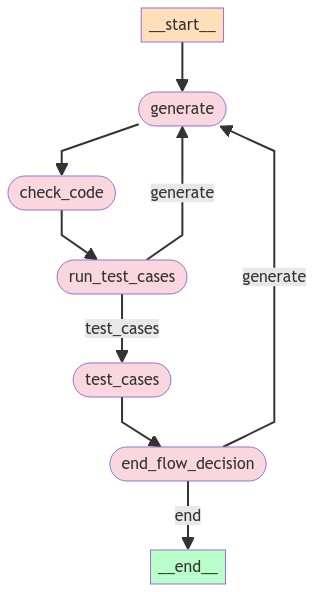

In [131]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

### Run the graph

In [132]:
import uuid
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

question = "Write a Python program that finds the index of the maximum value in a list."
for s in graph.stream(
    {"messages": [("user", question)], "iterations": 0, "error": "no"}, config, stream_mode="values"):
    print(s)

{'error': 'no', 'messages': [HumanMessage(content='Write a Python program that finds the index of the maximum value in a list.', id='f5b4b05d-decd-43dd-b723-4dcc973f6abb')], 'iterations': 0}


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")
Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'code_generation': AIMessage(content='{\n  "description": "This function finds the index of the maximum value in a list.",\n  "imports": "None",\n  "code": "def find_max_index(lst):\\n    if not lst:\\n        return -1\\n    max_index = 0\\n    for i in range(1, len(lst)):\\n        if lst[i] > lst[max_index]:\\n            max_index = i\\n    return max_index",\n  "test": {\n    "input": "result = find_max_index([1, 3, 7, 2, 5])\\nprint(result)",\n    "output": "2"\n  }\n}', response_metadata={'token_usage': {'completion_tokens': 138, 'prompt_tokens': 502, 'total_tokens': 640}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_f4e629d0a5', 'finish_reason': 'stop', 'logprobs': None}, id='run-30d560cf-7652-4dbd-85e5-1a025b53e335-0'), 'error': 'no', 'messages': [HumanMessage(content='Write a Python program that finds the index of the maximum value in a list.', id='f5b4b05d-decd-43dd-b723-4dcc973f6abb'), AIMessage(content="Here is my attempt to solve the problem: This function finds the

In [133]:
final_solution = s['code_generation'].content
final_solution = json.loads(final_solution)

pprint.pprint(final_solution)

{'code': 'def find_max_index(lst):\n'
         '    if not lst:\n'
         '        return -1\n'
         '    max_index = 0\n'
         '    for i in range(1, len(lst)):\n'
         '        if lst[i] > lst[max_index]:\n'
         '            max_index = i\n'
         '    return max_index',
 'description': 'This function finds the index of the maximum value in a list.',
 'imports': 'None',
 'test': {'input': 'result = find_max_index([1, 3, 7, 2, 5])\nprint(result)',
          'output': '2'}}


In [134]:
import uuid
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

question = "Write a Python program that takes two strings as input and returns the largest common substring between them."
for s in graph.stream(
    {"messages": [("user", question)], "iterations": 0, "error": "no"}, config, stream_mode="values"):
    print(s)

{'error': 'no', 'messages': [HumanMessage(content='Write a Python program that takes two strings as input and returns the largest common substring between them.', id='c9681290-5dbf-4965-8bf4-928d09904ebb')], 'iterations': 0}


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")
Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'code_generation': AIMessage(content='{\n  "description": "This function takes two strings as input and returns the largest common substring between them.",\n  "imports": "None",\n  "code": "def largest_common_substring(str1, str2):\\n    m = len(str1)\\n    n = len(str2)\\n    result = \'\'\\n    length = 0\\n    dp = [[0] * (n + 1) for _ in range(m + 1)]\\n\\n    for i in range(1, m + 1):\\n        for j in range(1, n + 1):\\n            if str1[i - 1] == str2[j - 1]:\\n                dp[i][j] = dp[i - 1][j - 1] + 1\\n                if dp[i][j] > length:\\n                    length = dp[i][j]\\n                    result = str1[i - length:i]\\n            else:\\n                dp[i][j] = 0\\n    return result",\n  "test": {\n    "input": "result = largest_common_substring(\'abcdef\', \'zcdemf\')\\nprint(result)",\n    "output": "cde"\n  }\n}', response_metadata={'token_usage': {'completion_tokens': 261, 'prompt_tokens': 634, 'total_tokens': 895}, 'model_name': 'gpt-4o', 'system

In [135]:
final_solution = s['code_generation'].content
final_solution = json.loads(final_solution)

pprint.pprint(final_solution)

{'code': 'def largest_common_substring(str1, str2):\n'
         '    m = len(str1)\n'
         '    n = len(str2)\n'
         "    result = ''\n"
         '    length = 0\n'
         '    dp = [[0] * (n + 1) for _ in range(m + 1)]\n'
         '\n'
         '    for i in range(1, m + 1):\n'
         '        for j in range(1, n + 1):\n'
         '            if str1[i - 1] == str2[j - 1]:\n'
         '                dp[i][j] = dp[i - 1][j - 1] + 1\n'
         '                if dp[i][j] > length:\n'
         '                    length = dp[i][j]\n'
         '                    result = str1[i - length:i]\n'
         '            else:\n'
         '                dp[i][j] = 0\n'
         '    return result',
 'description': 'This function takes two strings as input and returns the '
                'largest common substring between them.',
 'imports': 'None',
 'test': {'input': "result = largest_common_substring('abcdef', 'zcdemf')\n"
                   'print(result)',
          'o